In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
import matplotlib.gridspec as gridspec
#For plotting cities
from matplotlib.transforms import Bbox
import matplotlib.patheffects as PathEffects


In [11]:
DRIVE_PATH = "/Users/jerrylin/Google Drive/My Drive/CS+/Data/"
def full_path(filename):
    return DRIVE_PATH + filename

In [12]:
#Necessary to get election data for the comp_gmander_score func.
df2 = gpd.read_file(full_path('NCabs_VTD'))
election_data = df2.loc[:, ['VTD_num', "EL16G_PR_D", 'EL16G_PR_R', 'EL16G_PR_T']]

In [13]:
def comp_gmander_score(orig_filepath, pk_pct, rank_num):      
    orig = pd.read_csv(orig_filepath, sep='\t', header=None)
    orig[1] -= 1
    orig["sample_num"] = -1

    compliant = pd.read_csv(full_path("ensembles_main_rank_" + str(rank_num) + "_compliantVerbose.txt"), sep='\t', header=None)
    compliant.rename(columns={0:"sample_num", 1:"is_compliant"}, inplace=True)
    #Grab a list of compliant numbers
    compliant_nums = compliant[compliant.is_compliant==1].sample_num.tolist()

    #Takes about 5 seconds
    #Iterate through all the compliant samples and read in their data
    pd_lists = []
    for sample_num in compliant_nums:
        filepath = full_path("ensembles_main_rank_" + str(rank_num) 
                             + "_districtingMaps/districtingMap") + str(sample_num) + ".txt"
        new = pd.read_csv(filepath, sep='\t', header=None)
        new["sample_num"] = sample_num
        pd_lists.append(new)
    #Add original districting as a sample
    pd_lists.append(orig)

    final = pd.concat(pd_lists)
    final.rename(columns={0:"VTD_num", 1:"district"}, inplace=True)

    #Join with election data
    final = final.merge(election_data, how='left', on="VTD_num")

    #Group at district level
    grouped = final.groupby(["sample_num", "district"]).sum()

    #Grouped at the district level, calculate district-level stats like dem prop and rep prop
    grouped["dem_prop"] = grouped["EL16G_PR_D"]/grouped["EL16G_PR_T"]
    grouped['rep_prop'] = grouped["EL16G_PR_R"]/grouped["EL16G_PR_T"]
    grouped['dem_win'] = 0
    grouped.loc[grouped.dem_prop > grouped.rep_prop, "dem_win"] = 1
    grouped.drop(columns=['EL16G_PR_D', 'EL16G_PR_R', 'VTD_num'], inplace=True)

    flattened = grouped.reset_index()

    #Add district-level stats to each VTD
    final2 = final.merge(flattened, how="left", left_on=['sample_num', 'district'], right_on=['sample_num', 'district'])

    #The district_level data for original districting
    orig_dst_lvl = final2.loc[final2.sample_num==-1]
    comp_dst_lvl = final2.loc[final2.sample_num!=-1]

    #Add original districting data to each comparator VTD entry — for easy calculation of differences between comparator
    final3 = comp_dst_lvl.merge(orig_dst_lvl, how="left", left_on='VTD_num', right_on='VTD_num', suffixes=('', '_orig'))

    #these formulas come from Fig. 2 of Warrington's Packed Vtrs Cracked Vtrs
    final3['dem_cracked'] = 0
    final3.loc[(final3.dem_prop > final3.rep_prop) & (final3.dem_prop_orig < final3.rep_prop_orig), 'dem_cracked'] = 1
    final3['rep_cracked'] = 0
    final3.loc[(final3.rep_prop > final3.dem_prop) & (final3.rep_prop_orig < final3.dem_prop_orig), 'rep_cracked'] = 1

    final3['dem_packed'] = 0
    final3.loc[((final3.dem_prop_orig - final3.dem_prop) > pk_pct) & (final3.dem_prop > final3.rep_prop), 'dem_packed'] = 1
    final3['rep_packed'] = 0
    final3.loc[((final3.rep_prop_orig - final3.rep_prop) > pk_pct) & (final3.rep_prop > final3.dem_prop), 'rep_packed'] = 1

    final3['dem_crk_ppl'] = final3.dem_cracked * final3.EL16G_PR_D
    final3['dem_pk_ppl'] = final3.dem_packed * final3.EL16G_PR_D
    final3['rep_crk_ppl'] = final3.rep_cracked * final3.EL16G_PR_R
    final3['rep_pk_ppl'] = final3.rep_packed * final3.EL16G_PR_R

    final3['dem_gmandered'] = final3.dem_crk_ppl + final3.dem_pk_ppl
    final3['rep_gmandered'] = final3.rep_crk_ppl + final3.rep_pk_ppl
    final3['tot_gmandered'] = final3.dem_gmandered + final3.rep_gmandered

    results = final3[['sample_num', 'dem_gmandered', 'rep_gmandered', 'tot_gmandered']].groupby("sample_num").sum()
    results = results.sort_values(by="tot_gmandered").reset_index()
    least_gmandered = results.iloc[0]['sample_num']
    most_gmandered = results.iloc[-1]['sample_num']
    print("avg_tot_gmandered", results.tot_gmandered.mean())
    print("max_tot_gmandered", max(results.tot_gmandered))
    print("min_tot_gmandered", min(results.tot_gmandered))


    def plot_sample_num(sample_num):
        districts = final2.loc[final2.sample_num==sample_num].merge(df2, on='VTD_num', how='left')
        districts = gpd.GeoDataFrame(districts)
        districts.plot(figsize=(15,15),
                   column="rep_prop", cmap="bwr", legend=True, vmin=0, vmax=1)
        plt.title("Rep Vote Percentage Per District")

    #plot_sample_num(least_gmandered)
    #plot_sample_num(most_gmandered)
    
    return final3

In [14]:
def generate_dist_borders(orig_filepath):
    orig = pd.read_csv(orig_filepath, sep='\t', header=None).rename(columns={0:'VTD_num',1:'district'})
    merged = gpd.GeoDataFrame(orig.merge(df2, on='VTD_num'))
    districts = merged[['geometry', 'district']].dissolve(by='district')
    return districts

### Creating polished heatmaps

In [29]:
def heatmap2(districts, party, test, suffix=''):
    #Group by VTD_num to get probability statistics
    grouped = test.groupby('VTD_num').sum()
    total_comps = grouped.iloc[0]['sample_num_orig'] * -1
    grouped['pct_dem_crk'] = grouped.dem_cracked/total_comps
    grouped['pct_dem_pk'] = grouped.dem_packed/total_comps
    grouped['pct_rep_crk'] = grouped.rep_cracked/total_comps
    grouped['pct_rep_pk'] = grouped.rep_packed/total_comps
    #Merge with df2, which contains shapefiles
    gdf = gpd.GeoDataFrame(grouped.merge(df2, on="VTD_num"))
    #Read district shapefiles
    plt.rcParams['hatch.color'] = 'white'
    text_rectangles = []
    y_step = 0.1
    if party =='dem':

        dem_crk = gdf[gdf.pct_dem_crk != 0]
        dem_pk = gdf[gdf.pct_dem_pk != 0]

        base1 = dem_crk.plot(column='pct_dem_crk', cmap='Oranges', legend=True,  figsize=(18, 16), 
                             vmin=0, vmax=1, legend_kwds={'shrink': 0.3, 'label':'Percent Dem Cracked', 'orientation':'vertical','pad':-0.08}, hatch='.', aspect=1)
        ## doesn't seem to work (in making the labelsize bigger)                     
        fig = base1.figure
        cb_ax = fig.axes[1] 
        cb_ax.tick_params(labelsize=10)

        base2 = dem_pk.plot(ax=base1, column='pct_dem_pk', cmap='Purples', legend=True,  figsize=(18, 16), vmin=0, vmax=1, 
                            legend_kwds={'shrink': 0.3, 'label':'Percent Dem Packed', 'orientation':'vertical', 'pad':0}, aspect=1)
    else:
        rep_crk = gdf[gdf.pct_rep_crk != 0]
        rep_pk = gdf[gdf.pct_rep_pk != 0]

        base1 = rep_crk.plot(column='pct_rep_crk', cmap='Oranges', legend=True,  figsize=(18, 16), 
                             vmin=0, vmax=1, legend_kwds={'shrink': 0.3, 'label':'Percent Rep Cracked', 'orientation':'vertical','pad':-0.08}, hatch='.', aspect=1)
        base2 = rep_pk.plot(ax=base1, column='pct_rep_pk', cmap='Purples', legend=True,  figsize=(18, 16), vmin=0, vmax=1, 
                            legend_kwds={'shrink': 0.3, 'label':'Percent Rep Packed', 'orientation':'vertical', 'pad':0})
                            
    base3 = gdf_city.plot(ax = base2, facecolor = 'black', edgecolors='w', zorder=10)
    base4 = districts.plot(ax=base3, edgecolor='black', linewidth=1, facecolor='none')
    
    ### Plot Cities
    for x, y, label in zip(gdf_city.geometry.x, gdf_city.geometry.y, gdf_city.City):
        text = base4.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color='black')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

        rect = text.get_window_extent()
        for other_rect in text_rectangles:
            while Bbox.intersection(rect, other_rect):  # overlapping
                x, y = text.get_position()
                text.set_position((x, y - y_step))
                rect = text.get_window_extent()
        text_rectangles.append(rect)
    plt.axis('off')

    if party == 'dem':
        #plt.title('Percent of Democrats Packed and Cracked Relative to 1055 Comparators')
        plt.savefig(suffix + 'dem_pkcrk.png', dpi=300, bbox_inches='tight')
    else:
        #plt.title('Percent of Republicans Packed and Cracked Relative to 1055 Comparators')
        plt.savefig(suffix + 'rep_pkcrk.png', dpi=300, bbox_inches='tight')
    




In [27]:
#generate shapefiles using gen_dist_shapefiles.ipynb
orig_districts = gpd.read_file(full_path('judges_NCAbs_shapefiles_wlatlon'))
new_districts = gpd.read_file(full_path('judges_witness_shapefiles'))

In [26]:
#Using 2016 districting and comparing against the suite generated from judges
test_orig = comp_gmander_score(full_path('code_data_NC_NCAbs_Judges.txt'), 0.05, 0)
test_new = comp_gmander_score(full_path('judges_witness_pairings.txt'), 0.05, 0)

avg_tot_gmandered 1026842.0180094787
max_tot_gmandered 1526553
min_tot_gmandered 506334
avg_tot_gmandered 677520.1383886256
max_tot_gmandered 1129482
min_tot_gmandered 284617


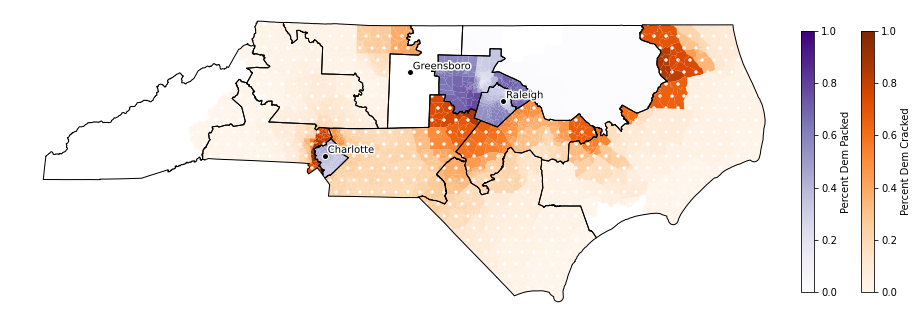

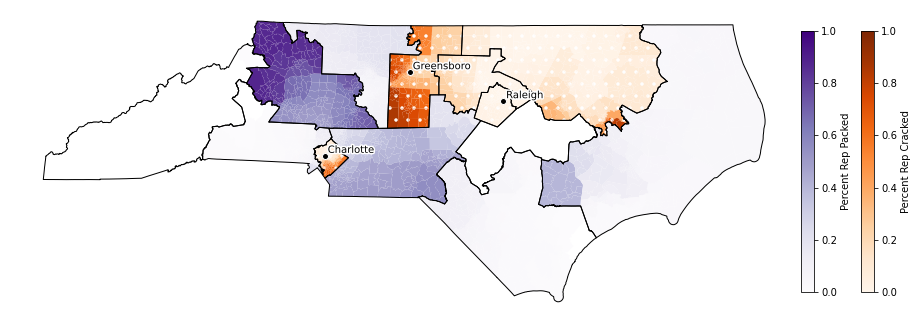

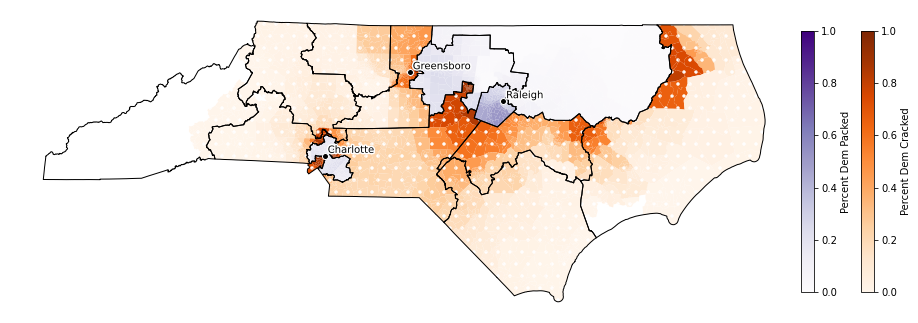

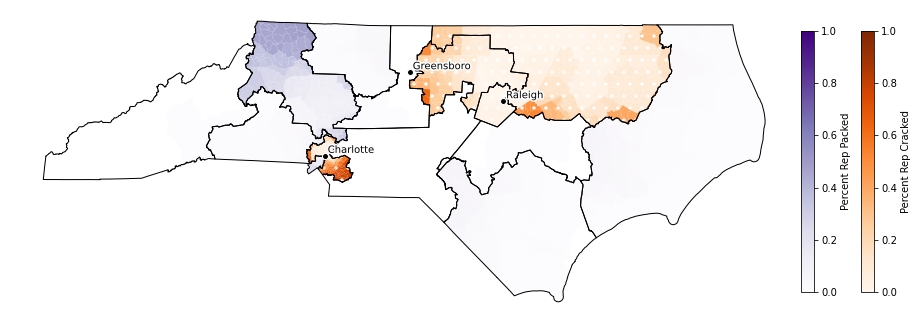

In [30]:
#note: load gdf_city in the next cell first! 
####original 2016 heatmaps
heatmap2(orig_districts, 'dem', test_orig, 'judges_')
heatmap2(orig_districts, 'rep', test_orig, 'judges_')
####post-swapping heatmaps
heatmap2(new_districts, 'dem', test_new, 'jwitness_')
heatmap2(new_districts, 'rep', test_new, 'jwitness_')

### Create non-partisan visualization

In [22]:
#Generate top 3 city points
city = pd.read_csv(full_path('city_long_lat.csv'))
city = city.loc[city.State == 'North Carolina'].nlargest(3, 'Population')
gdf_city = gpd.GeoDataFrame(
    city, geometry=gpd.points_from_xy(city.lon, city.lat))

In [53]:
def nonpartisan(scoredf, dist_shp_path, output_name):
    scoredf['percent_gmandered'] = scoredf['tot_gmandered']/scoredf['EL16G_PR_T_x']
    districts = gpd.read_file(dist_shp_path)
    #Get mean tot_gmandered for each VTD
    results = scoredf[['VTD_num', 'percent_gmandered']].groupby("VTD_num").mean()
    #Merge with df2, which contains shapefiles
    gdf = gpd.GeoDataFrame(results.merge(df2, on="VTD_num"))

    ## Begin plotting
    from matplotlib.transforms import Bbox
    import matplotlib.patheffects as PathEffects

    text_rectangles = []
    y_step = 0.1

    base1 = gdf.plot(column='percent_gmandered', cmap='Greens', legend=True,  figsize=(18, 16), vmin = 0, vmax = 0.9,
                                legend_kwds={'shrink': 0.3, 'label':'$g(v_j)$ per capita', 'orientation':'vertical'}, aspect=1)
    base2 = gdf_city.plot(ax = base1, facecolor = 'black', edgecolors='w', zorder=10)
    ax = districts.plot(ax=base2, edgecolor='black', linewidth=0.25, facecolor='none')
    for x, y, label in zip(gdf_city.geometry.x, gdf_city.geometry.y, gdf_city.City):
        text = ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color='black')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

        rect = text.get_window_extent()
        for other_rect in text_rectangles:
            while Bbox.intersection(rect, other_rect):  # overlapping
                x, y = text.get_position()
                text.set_position((x, y - y_step))
                rect = text.get_window_extent()
        text_rectangles.append(rect)


    #plt.title('$g(v_j)$ per capita')
    plt.axis('off')
    plt.savefig(output_name, dpi=300, bbox_inches='tight')

In [22]:
scoredf = comp_gmander_score(full_path('code_data_NC_NCAbs_2016.txt'), 0.05, 0)

avg_tot_gmandered 1151027.4312796209
max_tot_gmandered 1706437
min_tot_gmandered 557238


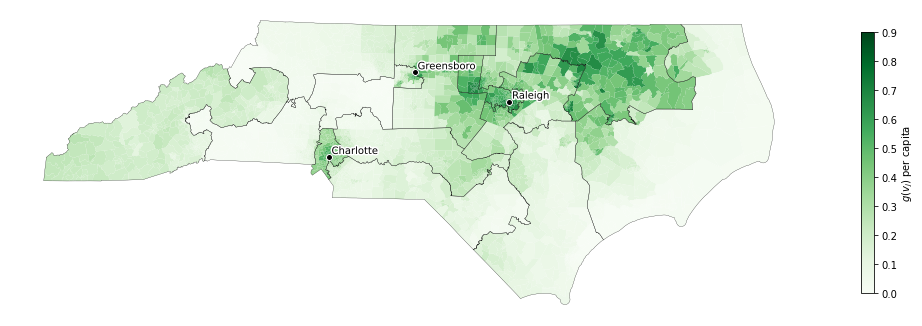

In [54]:
nonpartisan(scoredf, full_path('2016_NCAbs_shapefiles_wlatlon'), 'nonpartisan.png')

In [24]:
scoredf_570 = comp_gmander_score(full_path('570000.txt'), 0.05, 0)

avg_tot_gmandered 571611.0995260663
max_tot_gmandered 1077461
min_tot_gmandered 251881


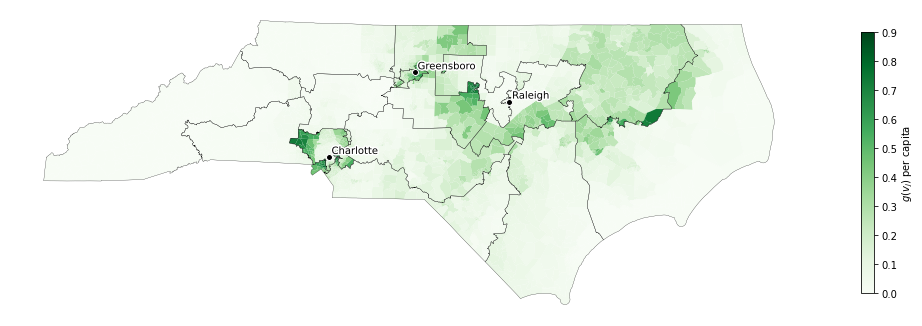

In [55]:
nonpartisan(scoredf_570, full_path('570000_NCAbs_shapefiles'), 'nonpartisan_570.png')

# Calculate demographic data

## Create demographic tables

In [14]:
def demographic_data_tbl(orig_file_path, orig_shp_path, gmander_2016):
    def polsby_popper(shape):
        return (4 * np.pi * shape.area) / (shape.length ** 2)
    pairings = pd.read_csv(orig_file_path, sep='\t', header=None).rename(columns={0:"VTD_num", 1:"district"})
    shapes = gpd.read_file(orig_shp_path).to_crs(epsg = 32119)
    shapes['pp'] = polsby_popper(shapes)
    gmander_2016 = gmander_2016.drop(columns='district').merge(pairings, on='VTD_num')
    gscore_dist = gmander_2016.groupby(['district', 'sample_num']).sum().reset_index().groupby('district').mean()[['dem_gmandered', 'rep_gmandered', 'tot_gmandered']]
    df2 = gpd.read_file(full_path('NCAbs_VTD'))
    demog_dist = df2.merge(pairings, on='VTD_num').groupby('district').sum().reset_index()
    table = demog_dist.merge(gscore_dist, on='district')
    table['dem_win'] = 0
    table.loc[table.EL16G_PR_D > table.EL16G_PR_R, "dem_win"] = 1
    table['rep_wasted'] = 0
    table['dem_wasted'] = 0
    for idx, row in table.iterrows():
        if row.dem_win == 1:
            table.loc[idx, 'dem_wasted'] = row.EL16G_PR_D - (row.EL16G_PR_T/2)
            table.loc[idx, 'rep_wasted'] = row.EL16G_PR_R
        else:
            table.loc[idx, 'dem_wasted'] = row.EL16G_PR_D
            table.loc[idx, 'rep_wasted'] = row.EL16G_PR_R  - (row.EL16G_PR_T/2)
    table['net_wasted'] = table['dem_wasted'] - table['rep_wasted']
    table = table.merge(shapes[['district', 'pp']], on='district')
    table = table[['district', 'tot_gmandered', 'EL16G_PR_D', 'EL16G_PR_R', 'VAP','BVAP', 'pp', 'net_wasted']]
    table['tot_gmandered'] = table.tot_gmandered.astype(int)
    table['net_wasted'] = table.net_wasted.astype(int)
    table = table.round({'pp': 3})
    return table

In [8]:
gmander_2016 = comp_gmander_score(full_path('code_data_NC_NCAbs_2016.txt'), 0.05, 0)

avg_tot_gmandered 1151027.4312796209
max_tot_gmandered 1706437
min_tot_gmandered 557238


In [15]:
table_2016 = demographic_data_tbl(full_path('code_data_NC_NCAbs_2016.txt'), 
full_path('2016_NCAbs_shapefiles_wlatlon'), gmander_2016)

In [10]:
gmander_570 = comp_gmander_score(full_path('570000.txt'), 0.05, 0)

avg_tot_gmandered 571611.0995260663
max_tot_gmandered 1077461
min_tot_gmandered 251881


In [16]:
table_570 = demographic_data_tbl(full_path('570000.txt'), full_path('570000_NCAbs_shapefiles'), gmander_2016)

In [17]:
table_2016.to_latex('table_2016.tex', index=False, header=['Dist.', 'g', 'Dem. Voters', 
'Rep. Voters','18+ Pop. (VAP)', 'Black VAP', 'Polsby-Popper', 'Net Wasted Votes'])

table_570.to_latex('table_570.tex', index=False, header=['Dist.', 'g', 'Dem. Voters', 
'Rep. Voters','18+ Pop. (VAP)', 'Black VAP', 'Polsby-Popper', 'Net Wasted Votes'])

## Create demographic figures

In [4]:
df2 = gpd.read_file(full_path('NCAbs_VTD'))

In [66]:
df2['aa_frac'] = df2.NH_BLACK/df2.TOTPOP

In [67]:
districts = gpd.read_file(full_path('2016_NCAbs_shapefiles_wlatlon'))

In [74]:
from matplotlib.transforms import Bbox
import matplotlib.patheffects as PathEffects

def annotate_city():
    #Grab top 5 city points
    city = pd.read_csv(full_path('city_long_lat.csv'))
    city = city.loc[city.State == 'North Carolina'].nlargest(3, 'Population')
    gdf_city = gpd.GeoDataFrame(
        city, geometry=gpd.points_from_xy(city.lon, city.lat))


    ax = gdf_city.plot(facecolor = 'black', edgecolors='w', zorder=10, figsize=(18, 16))


    text_rectangles = []
    y_step = 0.1
    for x, y, label in zip(gdf_city.geometry.x, gdf_city.geometry.y, gdf_city.City):
        text = ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points", color='black') #ha = 'center'?
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

        
        rect = text.get_window_extent()
        for other_rect in text_rectangles:
            while Bbox.intersection(rect, other_rect):  # overlapping
                x, y = text.get_position()
                text.set_position((x, y - y_step))
                rect = text.get_window_extent()
        text_rectangles.append(rect)
    return ax

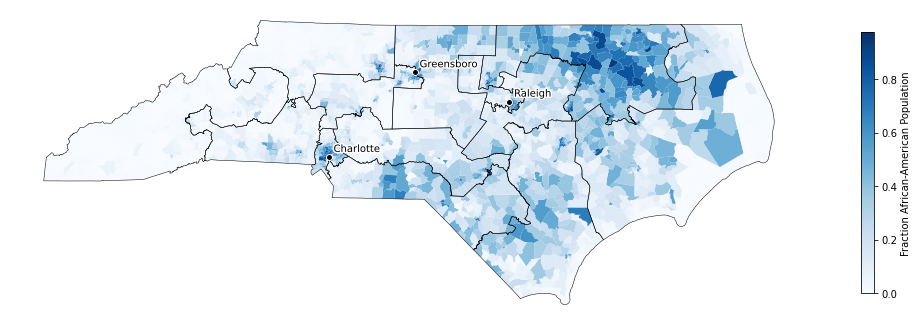

In [76]:
base1 = annotate_city()

base2 = df2.plot(ax = base1, column='aa_frac', cmap='Blues', legend=True, 
                             legend_kwds={'shrink': 0.3, 'label':'Fraction African-American Population', 'orientation':'vertical'}, aspect=1)
districts.plot(ax=base1, edgecolor='black', linewidth=0.5, facecolor='none')


#plt.title('Fraction African-American Population per VTD ')
plt.axis('off')
plt.savefig('aa_percent.png', dpi=300, bbox_inches='tight')

# Generate district partisan voting indexes & tables

### Create tables with seats won, efficiency gap

In [40]:
def electoral_info(pairings_path):
    print(pairings_path)
    #df2, election_data defined in header
    pairings = pd.read_csv(pairings_path, sep='\t', header=None).rename(columns={0:"VTD_num", 1:"district"})
    final = pairings.merge(election_data, how='left', on="VTD_num")
    grouped = final.groupby("district").sum()
    grouped["dem_prop"] = grouped["EL16G_PR_D"]/grouped["EL16G_PR_T"]
    grouped['rep_prop'] = grouped["EL16G_PR_R"]/grouped["EL16G_PR_T"]

    grouped['dem_win'] = 0
    grouped.loc[grouped.dem_prop > grouped.rep_prop, "dem_win"] = 1
    print('dem_win', grouped.dem_win.sum())

    for idx, row in grouped.iterrows():
        if row.dem_win == 1:
            grouped.loc[idx, 'dem_wasted'] = row.EL16G_PR_D - (row.EL16G_PR_T/2)
            grouped.loc[idx, 'rep_wasted'] = row.EL16G_PR_R
        else:
            grouped.loc[idx, 'dem_wasted'] = row.EL16G_PR_D
            grouped.loc[idx, 'rep_wasted'] = row.EL16G_PR_R  - (row.EL16G_PR_T/2)
    eff_gap = (grouped.dem_wasted.sum() - grouped.rep_wasted.sum())/grouped.EL16G_PR_T.sum()
    print('rep_favored', eff_gap)

In [41]:
electoral_info(full_path('code_data_NC_NCAbs_2016.txt'))
electoral_info(full_path('code_data_NC_NCAbs_2012.txt'))
electoral_info(full_path('acr_VTD.txt'))
electoral_info(full_path('code_data_NC_NCAbs_Judges.txt'))

/Users/jerrylin/Google Drive/My Drive/CS+/Data/code_data_NC_NCAbs_2016.txt
dem_win 3
rep_favored 0.22256068487464878
/Users/jerrylin/Google Drive/My Drive/CS+/Data/code_data_NC_NCAbs_2012.txt
dem_win 3
rep_favored 0.24493016119834457
/Users/jerrylin/Google Drive/My Drive/CS+/Data/acr_VTD.txt
dem_win 7
rep_favored -0.0897378753416666
/Users/jerrylin/Google Drive/My Drive/CS+/Data/code_data_NC_NCAbs_Judges.txt
dem_win 5
rep_favored 0.055003170598497776


### Get compactness


In [18]:
def compactness(orig_shp_path):
    def polsby_popper(shape):
        return (4 * np.pi * shape.area) / (shape.length ** 2)
    shapes = gpd.read_file(orig_shp_path).to_crs(epsg = 32119)
    shapes['pp'] = polsby_popper(shapes)
    return round(shapes.pp.mean(), 5)

In [19]:
print('2012', compactness(full_path('2012_NCAbs_shapefiles_wlatlon')))
print('2016', compactness(full_path('2016_NCAbs_shapefiles_wlatlon')))
print('acr', compactness(full_path('acr_NCAbs_shapefiles_wlatlon')))
print('judges', compactness(full_path('judges_NCAbs_shapefiles_wlatlon')))

2012 0.11867
2016 0.24774
acr 0.30971
judges 0.33094


### Create some shapefiles wlatlon

In [10]:
## USED this to create 2012_NCAbs_shapefiles_wlatlon
def generate_dist_borders(orig_filepath):
    orig = pd.read_csv(orig_filepath, sep='\t', header=None).rename(columns={0:'VTD_num',1:'district'})
    merged = gpd.GeoDataFrame(orig.merge(df2, on='VTD_num'))
    districts = merged[['geometry', 'district']].dissolve(by='district')
    return districts

In [27]:
acr = generate_dist_borders(full_path('acr_VTD.txt'))

In [30]:
acr.to_file(full_path('acr_NCAbs_shapefiles_wlatlon'))

In [31]:
judges = generate_dist_borders(full_path('code_data_NC_NCAbs_Judges.txt'))

In [32]:
judges.to_file(full_path('judges_NCAbs_shapefiles_wlatlon'))

In [58]:
low = generate_dist_borders(full_path('570000.txt'))

In [59]:
low.to_file(full_path('570000_NCAbs_shapefiles_wlatlon'))

### Plot partisan voting indexes

In [8]:
#Generate top 3 city points
city = pd.read_csv(full_path('city_long_lat.csv'))
city = city.loc[city.State == 'North Carolina'].nlargest(3, 'Population')
gdf_city = gpd.GeoDataFrame(
    city, geometry=gpd.points_from_xy(city.lon, city.lat))

In [22]:
def plot_dist_partisaness(pairings_path, shp_path, plt_title, pt_type = 'rep', get_seats = False):
    
    #df2, election_data defined in header
    curr_dist_shapes = gpd.read_file(shp_path)
    #in case some files have uppercase District
    curr_dist_shapes.rename(columns={'District':'district'}, inplace=True)

    pairings = pd.read_csv(pairings_path, sep='\t', header=None).rename(columns={0:"VTD_num", 1:"district"})
    final = pairings.merge(election_data, how='left', on="VTD_num")
    grouped = final.groupby("district").sum()
    grouped["dem_prop"] = grouped["EL16G_PR_D"]/grouped["EL16G_PR_T"]
    grouped['rep_prop'] = grouped["EL16G_PR_R"]/grouped["EL16G_PR_T"]
    if get_seats:
        grouped['dem_win'] = 0
        grouped.loc[grouped.dem_prop > grouped.rep_prop, "dem_win"] = 1
        print(grouped.dem_win.sum())
        return None; 


    #Expensive operation
    curr_dist_shapes["rep_prop"] = grouped['rep_prop'].round(3).values
    if pt_type == 'centroid':
        curr_dist_shapes['coords'] = curr_dist_shapes['geometry'].apply(lambda x: x.centroid.coords[:])
    else:   
        curr_dist_shapes['coords'] = curr_dist_shapes['geometry'].apply(lambda x: x.representative_point().coords[:])
    curr_dist_shapes['coords'] = [coords[0] for coords in curr_dist_shapes['coords']]

    ### PLOTTING
    from matplotlib.transforms import Bbox
    import matplotlib.patheffects as PathEffects
    text_rectangles = []
    y_step = 0.1
    base1 = gdf_city.plot(facecolor = 'black', edgecolors='w', zorder=10, figsize=(18, 16))
    ax = curr_dist_shapes.plot(ax=base1,
               column="rep_prop", cmap="coolwarm", legend=True, vmin=0, vmax=1, edgecolor="black", legend_kwds={'shrink': 0.3, 
               'label': 'Republican Vote Fraction', 'pad':0})

    for idx, row in curr_dist_shapes.iterrows():
        text = plt.annotate(s=row['district'], xy=row['coords'],
                     horizontalalignment='center')

        rect = text.get_window_extent()
        for other_rect in text_rectangles:
            while Bbox.intersection(rect, other_rect):  # overlapping
                x, y = text.get_position()
                text.set_position((x, y - y_step))
                rect = text.get_window_extent()
        text_rectangles.append(rect)
        
    for x, y, label in zip(gdf_city.geometry.x, gdf_city.geometry.y, gdf_city.City):
        text = ax.annotate(label, xy=(x, y), xytext=(5, 5), textcoords="offset points", color='black')
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

        rect = text.get_window_extent()
        for other_rect in text_rectangles:
            while Bbox.intersection(rect, other_rect):  # overlapping
                x, y = text.get_position()
                text.set_position((x, y - y_step))
                rect = text.get_window_extent()
        text_rectangles.append(rect)


    #plt.title("Republican Vote Percentage Per District")
    
    plt.axis('off')
    plt.savefig(plt_title, dpi=300, bbox_inches='tight')

In [ ]:
plot_dist_partisaness(full_path('code_data_NC_NCAbs_2016.txt'), full_path('2016_NCAbs_shapefiles_wlatlon'), '2016_vote.png')

In [ ]:
plot_dist_partisaness(full_path('code_data_NC_NCAbs_2012.txt'), full_path('2012_NCAbs_shapefiles_wlatlon'), '2012_vote.png')

In [ ]:
plot_dist_partisaness(full_path('code_data_NC_NCAbs_Judges.txt'), full_path('judges_NCAbs_shapefiles_wlatlon'), 'judges_vote.png', 'centroid')

In [ ]:
plot_dist_partisaness(full_path('acr_VTD.txt'), full_path('acr_NCAbs_shapefiles_wlatlon'), 'acr_vote.png')

In [ ]:
plot_dist_partisaness(full_path('570000.txt'), full_path('570000_NCAbs_shapefiles_wlatlon'), '570000_vote.png')

In [23]:
# Get number of wins per district for 2012 map since it's competitive
plot_dist_partisaness(full_path('code_data_NC_NCAbs_2012.txt'), full_path('2012_NCAbs_shapefiles_wlatlon'), '2012_vote.png', get_seats=True)
plot_dist_partisaness(full_path('code_data_NC_NCAbs_Judges.txt'), full_path('judges_NCAbs_shapefiles_wlatlon'), 'judges_vote.png', get_seats=True)

3
5


# Generate overall district maps

In [6]:
readin = pd.read_csv(full_path('compdev0.1starttemp800.0tempfac0.9747use_alphaFalsealpha5222.0pairings.txt'), sep='\t', header=None).rename(columns={0:"VTD_num", 1:"district"})
merged = readin.merge(df2, on='VTD_num')

(-84.7679565, -74.9540315, 33.61111405, 36.72992094999999)

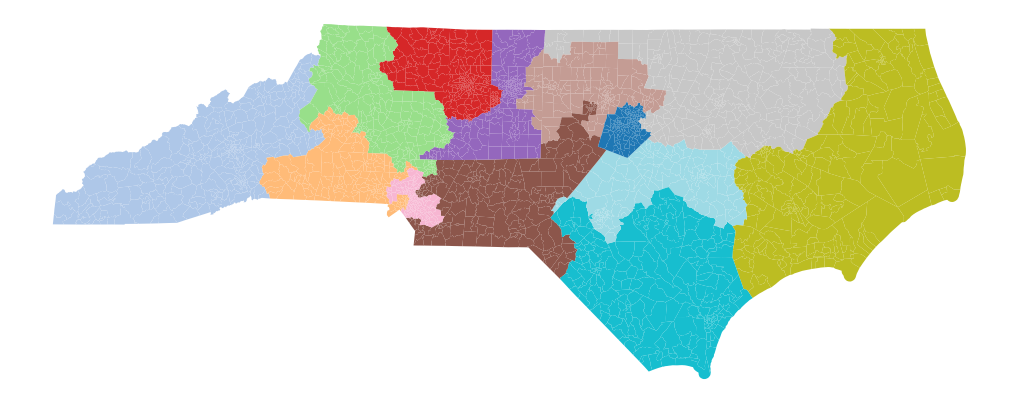

In [7]:
gpd.GeoDataFrame(merged).plot(column='district', figsize=(18,16), cmap='tab20')
plt.axis('off')